# INL Stability Analysis

This notebook reproduces the stability visualizations and simulations for the Integrator Neuron Layer (INL) dynamics. It contains:

- spectral radius heatmap over $(\alpha, p)$ where $p = dt\cdot g\cdot\beta$
- contour boundary where spectral radius == 1
- eigenvalue magnitude checks for example parameter sets
- simulation of energy $E(n) = \tfrac12\|x-\mu\|^2 + \tfrac12\|v\|^2$ for representative parameters

The notebook is ready to run in a local environment (Python 3.8+, NumPy, Matplotlib, PyTorch optional).

In [17]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import json
import os

print('Libraries imported')

# Create output directory
output_dir = r'c:\dev\inl\inl_notebook_outputs'
os.makedirs(output_dir, exist_ok=True)
print('Output directory:', output_dir)


Libraries imported
Output directory: c:\dev\inl\inl_notebook_outputs


## Helper functions

Define functions for spectral radius, simulation and plotting.

In [18]:
def spectral_radius(alpha, p):
    # alpha in [0,1), p = dt*g*beta
    a11 = 1 - p
    a12 = p * alpha
    a21 = -1.0
    a22 = alpha
    trace = a11 + a22
    det = a11 * a22 - a12 * a21
    disc = trace*trace - 4*det
    sqrt_disc = np.sqrt(np.maximum(disc, 0.0))
    lam1 = 0.5 * (trace + sqrt_disc)
    lam2 = 0.5 * (trace - sqrt_disc)
    return np.maximum(np.abs(lam1), np.abs(lam2))

def simulate_inl(alpha, beta, dt, g, dim=128, steps=200, seed=0, excite=False):
    rng = np.random.RandomState(seed)
    mu = rng.normal(scale=0.1, size=(dim,))
    v_target = np.zeros(dim)
    x = rng.normal(scale=1.0, size=(dim,))
    v = rng.normal(scale=1.0, size=(dim,))
    E = []
    for n in range(steps):
        error = x - mu
        v_next = alpha * v - beta * error
        x_next = x + dt * g * v_next
        x, v = x_next, v_next
        En = 0.5 * np.sum((x - mu)**2) + 0.5 * np.sum((v - v_target)**2)
        E.append(En)
        if excite and n % 10 == 0:
            x += 0.001 * rng.normal(size=x.shape)
    return np.array(E)


## Spectral radius heatmap
Compute and plot the spectral radius over a grid of (alpha, p).

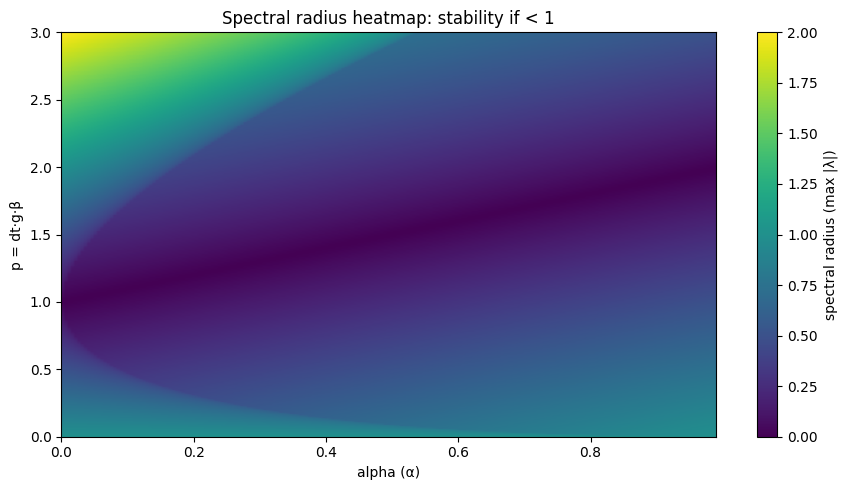

Saved heatmap to c:\dev\inl\inl_notebook_outputs\spectral_radius_heatmap.png


In [19]:
alphas = np.linspace(0.0, 0.99, 201)
ps = np.linspace(0.0, 3.0, 301)
R = np.empty((len(ps), len(alphas)))
for i, p in enumerate(ps):
    for j, a in enumerate(alphas):
        R[i, j] = spectral_radius(a, p)

import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
plt.imshow(R, origin='lower', aspect='auto', extent=[alphas[0], alphas[-1], ps[0], ps[-1]])
plt.colorbar(label='spectral radius (max |λ|)')
plt.xlabel('alpha (α)')
plt.ylabel('p = dt·g·β')
plt.title('Spectral radius heatmap: stability if < 1')
plt.tight_layout()
figpath = os.path.join(output_dir, 'spectral_radius_heatmap.png')
plt.savefig(figpath, dpi=150)
plt.show()
print('Saved heatmap to', figpath)

## Stability contour
Plot contour where spectral radius = 1.

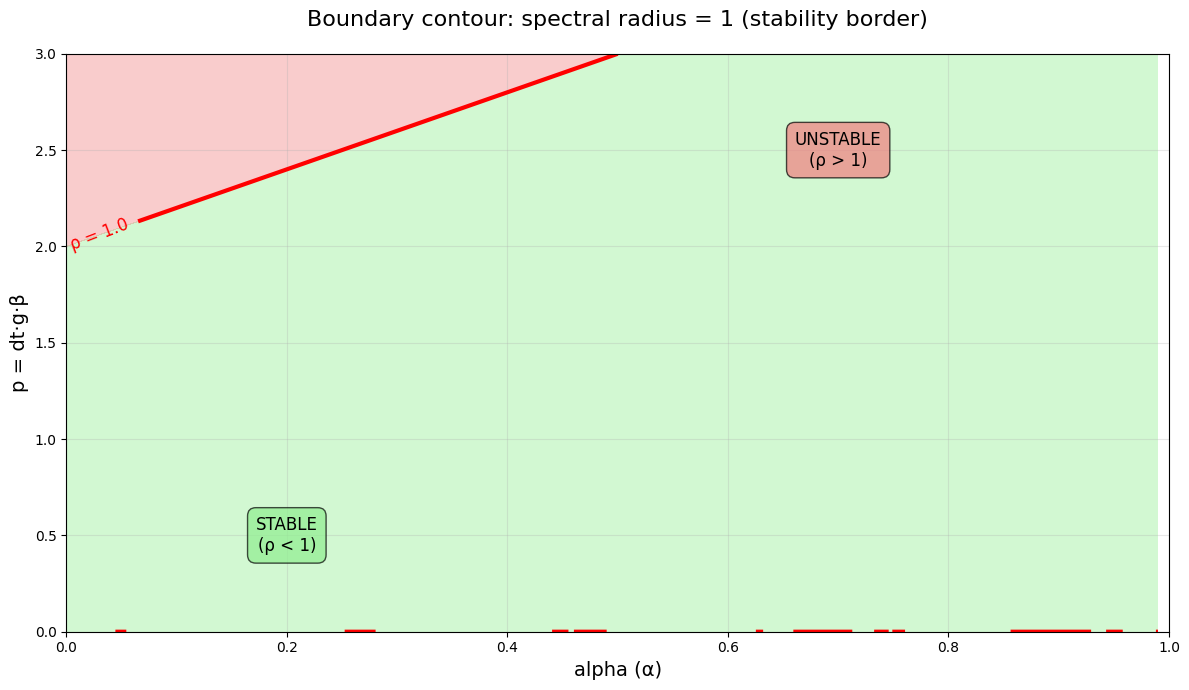

Saved contour to c:\dev\inl\inl_notebook_outputs\stability_contour.png


In [25]:
plt.figure(figsize=(12,7))
CS = plt.contour(alphas, ps, R, levels=[1.0], linewidths=3, colors='red')
plt.clabel(CS, fontsize=12, inline=1, fmt='ρ = %.1f')

# Add filled contours to show stable/unstable regions
plt.contourf(alphas, ps, R, levels=[0, 1.0, R.max()], colors=['lightgreen', 'lightcoral'], alpha=0.4)

plt.xlabel('alpha (α)', fontsize=14)
plt.ylabel('p = dt·g·β', fontsize=14)
plt.title('Boundary contour: spectral radius = 1 (stability border)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)

# Add text annotations for regions
plt.text(0.2, 0.5, 'STABLE\n(ρ < 1)', fontsize=12, ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))
plt.text(0.7, 2.5, 'UNSTABLE\n(ρ > 1)', fontsize=12, ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7))

# Set better axis limits
plt.xlim(0, 1)
plt.ylim(0, 3)

plt.tight_layout()
figpath = os.path.join(output_dir, 'stability_contour.png')
plt.savefig(figpath, dpi=150, bbox_inches='tight')
plt.show()
print('Saved contour to', figpath)

## Eigenvalue magnitudes (examples)
Check eigenvalue magnitudes for representative parameter choices.

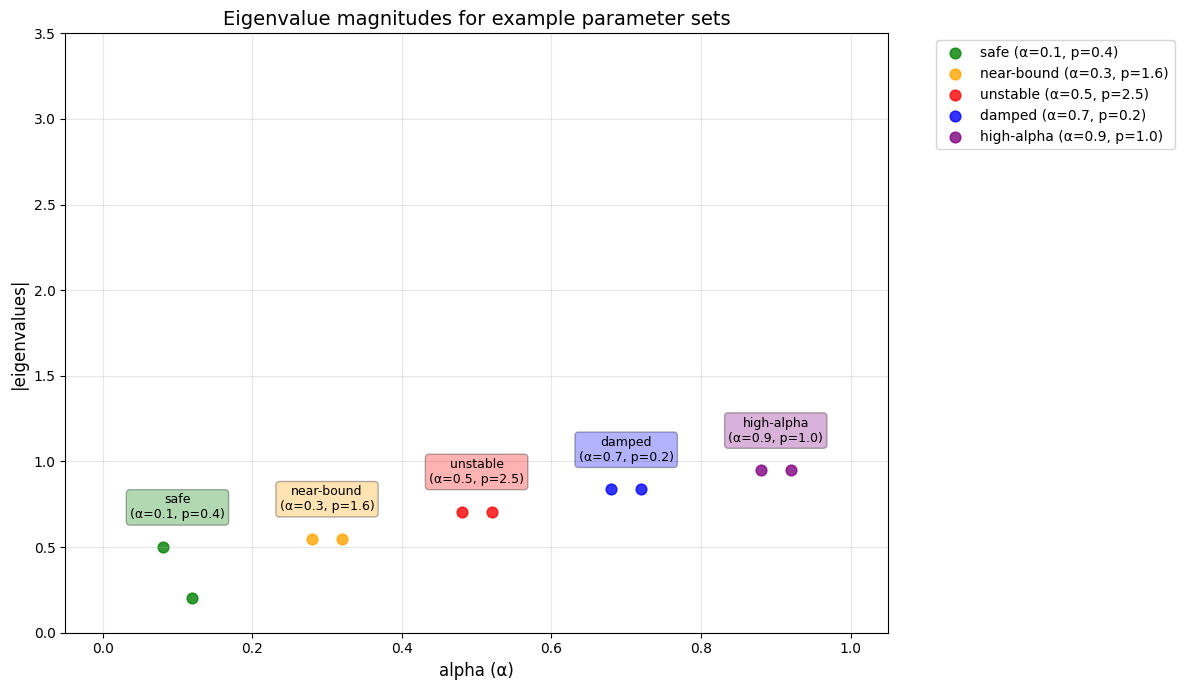

Saved eigenvalue plot to c:\dev\inl\inl_notebook_outputs\eigenvalue_examples.png


In [24]:
examples = [
    (0.1, 0.4, 'safe'),
    (0.3, 1.6, 'near-bound'), 
    (0.5, 2.5, 'unstable'),
    (0.7, 0.2, 'damped'),
    (0.9, 1.0, 'high-alpha')
]

plt.figure(figsize=(12,7))
colors = ['green', 'orange', 'red', 'blue', 'purple']

for idx, (a, p, label) in enumerate(examples):
    A = np.array([[1-p, p*a], [-1.0, a]])
    vals = np.linalg.eigvals(A)
    
    # Plot the two eigenvalues for each parameter set
    y_vals = [np.abs(vals[0]), np.abs(vals[1])]
    x_vals = [a - 0.02, a + 0.02]
    
    plt.scatter(x_vals, y_vals, marker='o', s=60, color=colors[idx], 
               label=f'{label} (α={a}, p={p})', alpha=0.8)
    
    # Add text annotation with better positioning
    max_y = max(y_vals)
    plt.annotate(f'{label}\n(α={a}, p={p})', 
                xy=(a, max_y), xytext=(a, max_y + 0.15),
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[idx], alpha=0.3))

plt.xlabel('alpha (α)', fontsize=12)
plt.ylabel('|eigenvalues|', fontsize=12)
plt.title('Eigenvalue magnitudes for example parameter sets', fontsize=14)
plt.ylim(0, 3.5)
plt.xlim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
figpath = os.path.join(output_dir, 'eigenvalue_examples.png')
plt.savefig(figpath, dpi=150, bbox_inches='tight')
plt.show()
print('Saved eigenvalue plot to', figpath)

## Energy simulation trajectories
Simulate energy decay for representative parameters and plot.

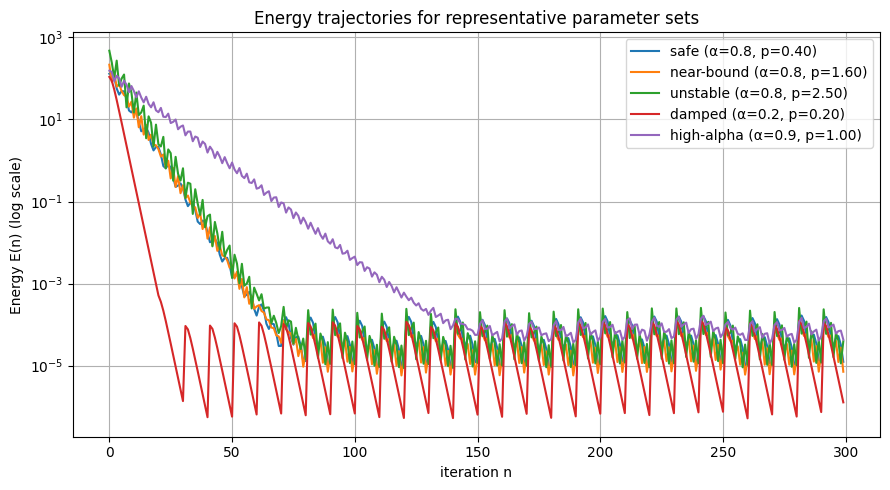

Saved energy plot to c:\dev\inl\inl_notebook_outputs\energy_trajectories.png


In [22]:
sim_params = [
    {'alpha':0.8,'beta':1.0,'dt':0.4,'g':1.0,'label':'safe'},
    {'alpha':0.8,'beta':1.0,'dt':1.6,'g':1.0,'label':'near-bound'},
    {'alpha':0.8,'beta':1.0,'dt':2.5,'g':1.0,'label':'unstable'},
    {'alpha':0.2,'beta':1.0,'dt':0.2,'g':1.0,'label':'damped'},
    {'alpha':0.9,'beta':1.0,'dt':1.0,'g':1.0,'label':'high-alpha'}
]

plt.figure(figsize=(9,5))
for p in sim_params:
    E = simulate_inl(p['alpha'], p['beta'], p['dt'], p['g'], steps=300, seed=42, excite=True)
    plt.plot(E, label=f"{p['label']} (α={p['alpha']}, p={p['dt']*p['g']*p['beta']:.2f})")
plt.yscale('log')
plt.xlabel('iteration n')
plt.ylabel('Energy E(n) (log scale)')
plt.title('Energy trajectories for representative parameter sets')
plt.legend()
plt.grid(True)
plt.tight_layout()
figpath = os.path.join(output_dir, 'energy_trajectories.png')
plt.savefig(figpath, dpi=150)
plt.show()
print('Saved energy plot to', figpath)

## Save numerical report
Save a JSON report with approximate p_break (first p where spectral radius >= 1) for sampled alphas.

In [23]:
safe_mask = R < 1.0
p_break = []
for j, a in enumerate(alphas):
    col = R[:, j]
    idx = np.where(col >= 1.0)[0]
    if idx.size == 0:
        p_break.append(None)
    else:
        p_break.append(float(ps[idx[0]]))
report = {
    'note': 'p = dt*g*beta. This report assumes beta=g=1 for mapping; scale accordingly.',
    'alpha_samples': alphas.tolist()[::20],
    'p_break_samples': [p_break[i] for i in range(0, len(p_break), 20)],
    'theoretical_sufficient_rule': '0 <= alpha < 1 and 0 < p < 2*(1+alpha)'
}
report_path = os.path.join(output_dir, 'inl_stability_report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)
print('Saved report to', report_path)

Saved report to c:\dev\inl\inl_notebook_outputs\inl_stability_report.json


## How to use this notebook
- Open in Jupyter / VS Code and run all cells.
- Figures and JSON report will be saved under `c:\dev\inl\inl_notebook_outputs`.
- To adapt to non-unit beta/g, remember $p = dt\cdot g\cdot\beta$ and scale accordingly.

If you want, I can also produce a condensed PDF report from the figures.